In [132]:
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import sys
from io import StringIO
import statsmodels.api as sm
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [133]:
#set up DF
cardiodf = pd.read_csv('/Users/Sanne/Downloads/cardio_train.csv', delimiter=';')

cardiodf['age']=cardiodf['age']//365
cardiodf=cardiodf.sort_values('height')
cardiodf['BMI'] = round(cardiodf['weight']/((cardiodf['height']/100)**2),2)

for i in cardiodf.index:
    if cardiodf['BMI'][i] > 100:
        cardiodf = cardiodf.drop(i)
        
cardiodf['pressure_difference'] = cardiodf.ap_hi - cardiodf.ap_lo        

print(cardiodf)

          id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
224      309   59       2      76    55.0    120     80            1     1   
28737  41075   54       1      91    55.0    140     90            1     1   
56022  79917   58       1      96    59.0     90     60            1     1   
17277  24690   48       1      98    45.0     12     80            1     1   
65302  93223   50       1      99    60.0     90     60            1     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
40090  57307   58       1     198    99.0    140     80            1     1   
8897   12687   61       2     198    79.0    160    100            1     1   
41901  59847   52       2     200   100.0    170   1100            2     2   
21628  30894   52       2     207    78.0    100     70            1     1   
6486    9223   58       1     250    86.0    140    100            3     1   

       smoke  alco  active  cardio    BMI  pressure_difference 

In [134]:
#women df
women_df = cardiodf[cardiodf.gender == 1]
age_stats_w = women_df['age'].describe()
bmi_stats_w = women_df['BMI'].describe()
pressure_stats_w = women_df['pressure_difference'].describe()

print(age_stats_w)
print(bmi_stats_w)
print(pressure_stats_w)

count    45510.000000
mean        52.954823
std          6.670227
min         29.000000
25%         49.000000
50%         54.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64
count    45510.000000
mean        27.925370
std          5.661326
min          8.000000
25%         23.880000
50%         26.710000
75%         31.020000
max         86.780000
Name: BMI, dtype: float64


In [162]:
#men df

men_df = cardiodf[cardiodf.gender == 2]
age_stats = men_df['age'].describe()
bmi_stats = men_df['BMI'].describe()
pressure_stats = men_df['pressure_difference'].describe()
print(age_stats)
print(bmi_stats)
print(pressure_stats)


count    24461.000000
mean        52.630187
std          6.937369
min         29.000000
25%         47.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64
count    24461.000000
mean        26.706330
std          4.498638
min          3.470000
25%         23.780000
50%         25.910000
75%         29.040000
max         95.220000
Name: BMI, dtype: float64
count    24461.000000
mean        29.518867
std        255.365436
min      -9860.000000
25%         40.000000
50%         40.000000
75%         50.000000
max      13940.000000
Name: pressure_difference, dtype: float64


Average age of Men:  52.954823115798725
Average age of Women:  52.63018682801194


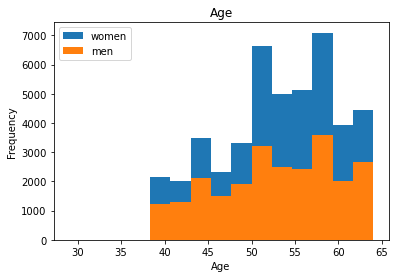

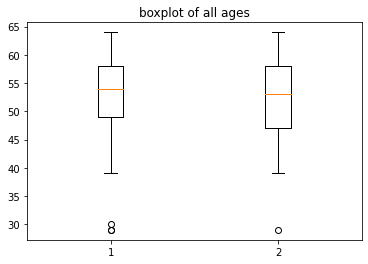

In [136]:
#histogram with ages male and female.
women_ages =women_df['age'].tolist()

women_average = sum(women_ages)/len(women_ages)
women_histo = plt.hist(women_ages, bins=15)
men_ages = men_df['age'].tolist()
men_average = sum(men_ages)/len(men_ages)
print('Average age of Men: ',women_average)
print('Average age of Women: ', men_average)
plt.hist(men_ages,bins=15)
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.gca().legend(('women','men'))
plt.show()
all_ages=[women_ages,men_ages]
plt.boxplot(all_ages, notch=None, patch_artist=None, widths=None)
plt.title('boxplot of all ages')
plt.show()

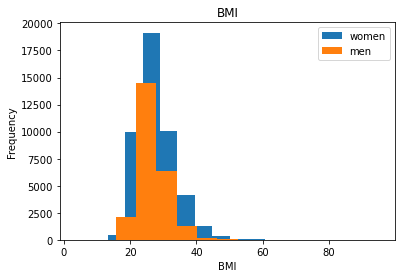

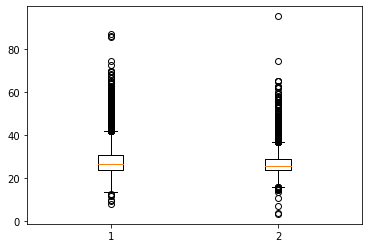

In [137]:
#visualizations of BMI
women_bmi = women_df['BMI'].tolist()
plt.hist(women_bmi, bins=15)
men_bmi = men_df['BMI'].tolist()
plt.hist(men_bmi, bins=15)
plt.title('BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.gca().legend(('women','men'))
plt.show()
all_bmi = [women_bmi, men_bmi]
plt.boxplot(all_bmi, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

In [153]:
#counting method
def frequency_table(df, column):
    freq_table = pd.crosstab(index=df[column], columns="count") 
    return freq_table


In [154]:
frequency_table(women_df, 'cholesterol')

col_0,count
cholesterol,
1,33552
2,6403
3,5555


In [155]:
frequency_table(men_df, 'cholesterol')

col_0,count
cholesterol,
1,18807
2,3146
3,2508


In [156]:
frequency_table(women_df, 'smoke')

col_0,count
smoke,
0,44698
1,812


In [157]:
frequency_table(men_df, 'smoke')

col_0,count
smoke,
0,19107
1,5354


In [160]:
frequency_table(women_df, 'alco')

col_0,count
alco,
0,44350
1,1160


In [161]:
frequency_table(men_df, 'alco')

col_0,count
alco,
0,21859
1,2602


In [158]:
frequency_table(women_df, 'cardio')

col_0,count
cardio,
0,22904
1,22606


In [159]:
frequency_table(men_df, 'cardio')

col_0,count
cardio,
0,12101
1,12360


In [139]:
def test_significance(p_value):
    if p_value <0.05:
        result = 'significant difference'
    else:
        result = 'no significant difference'
    return result

In [140]:
def perform_tests(df, column):
    sick  =df[df['cardio']==1]
    non_sick = df[df['cardio']==0]
    
    p_value = stats.ranksums(sick[column],non_sick[column]).pvalue
    diff = test_significance (p_value)
        
    return diff

In [141]:
perform_tests(women_df,'age')

'significant difference'

In [142]:
perform_tests(men_df,'age')

'significant difference'

In [143]:
perform_tests(women_df,'BMI')


'significant difference'

In [144]:
perform_tests(men_df, 'BMI')

'significant difference'

In [146]:
perform_tests(women_df, 'pressure_difference')

'significant difference'

In [147]:
perform_tests(men_df, 'pressure_difference')

'significant difference'

In [ ]:

def dif_bmi_age_groups(df):
    mini = int(df['age'].min())
    # print(mini)
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    # print(mini)
    
    maxi = int(df['age'].max())
    # print(maxi)
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    # print(maxi)
    results = []
    #change this part to BMI
    
    for i in range(mini, maxi, 10):
        # print(df.loc[df.age >= i].loc[df.age < i + 10 ])
        mm = difference_bmi(df.loc[df.age >= i].loc[df.age < i + 10 ])
        results.append([round(mm,1), i])
    return results
    

print(dif_blood_age_groups(df))
'''There is a difference between difference gaps between blood pressures of each age group'''
